# Analyze Wuzzuf Data

This data draws on data scraped from Wuzzuf.com related to job advertisement in Egypt to:

1. cleans the data so it is useful for regression analysis 
2. select out key nouns and words from the requirements section of the job advertisements
3. produce word clouds that highlight key skills and qualifications desired for different occupations

Code was developed for paper "Improving Labor Market Matching in Egypt"

#### Created by Natalie Chun (20 September - 15 October 2017)

In [162]:
# import relevant packages for processing data

import csv
import pandas as pd
import numpy as np
import re
from datetime import datetime
import nltk

In [163]:
#keepcols = ['job-company-location','num_applicants','num_vacancies','num_reviews','num_shortlist','num_rejected','experience','career_level','job_type','salary','education_level']
#note that salary needs to be unicoded
keepcols = ['job-company-name','job-company-location','postdate','num_applicants','num_vacancies','num_reviewed','num_shortlist','num_rejected','experience_needed','career_level','job_type','education_level','gender','travel_frequency','languages','vacancies','job_roles','industries','requirements']
jdata = pd.read_csv('Wuzzuf_jobdata_08302017.csv',usecols=keepcols)
#list out variables in the data
jdata.dtypes

job-company-name        object
job-company-location    object
postdate                object
num_applicants          object
num_vacancies            int64
num_reviewed            object
num_shortlist            int64
num_rejected             int64
experience_needed       object
career_level            object
job_type                object
education_level         object
gender                  object
travel_frequency        object
languages               object
vacancies               object
job_roles               object
requirements            object
industries              object
dtype: object

In [164]:
#read the following items into dictionary that will be used for mapping industry and job data
with open('wuzzuf_industry_list_mapping.csv', mode='r') as infile:
    reader = csv.reader(infile)
    ind_mapping = {rows[0]:rows[1] for rows in reader}
    infile.close()

with open('wuzzuf_job_list_mapping.csv', mode='r') as infile:
    reader = csv.reader(infile)
    job_mapping = {rows[0]:rows[1] for rows in reader}
    infile.close()

In [165]:
# test processing of requirements column
linetext = []
print(jdata['requirements'][0].strip("[").strip("]").split(','))

["b'max 1 year of experience'", " b'a good command of english'", ' b\'familiar with ms office "word', ' excel and powerpoint"\'', " b'have excellent communication skills'", " b'sales oriented character'", " b'e-mail communication'", " b'good looking'"]


In [166]:
#this checks the text in the requirements section to identify key words to focus on
#it cleans the requirements section data that will be better for processing and analysis
keywords = []
alltext = []
notation = ['\"','''\'''',"-","(",")","[","]",";","."]
for i, row in jdata.iterrows():
    # Replace any non-letter, space, or digit character in the headlines.
    linetext = []
    text = row['requirements'].strip("[").strip("]").split(',')
    for t in text:
        #print(t)
        t = t.strip()
        t = re.sub(r'^b[\'|\"]','',t)
        t = re.sub(r'\\x[\\x|\w+]','',t)
        t = re.sub(r'[\d]',"",t)
        t = re.sub('\s+'," ",t)
        for n in notation:
            t = t.replace(n,"")
        t = re.sub(r'(bs/ba|university|bachelors|masters)','bachelor',t)
        t = re.sub(r'leaders[\s|$]','leadership',t)
        t = re.sub(r'[^|\s]ms\s','microsoft',t)
        t = re.sub(r'good looking','good-looking',t)
        t = re.sub(r'hard working','hard-working',t)
        t = re.sub(r'attention to detail','attention-to-detail',t)
        t = t.replace('\\','')
        linetext.append(t)
    alltext.append(' '.join(linetext))
    
print(len(alltext))
jdata['clean_requirements'] = alltext
fulltext = ' '.join(alltext)
print(jdata['clean_requirements'].head(20))     

# cleans the requirements text by removing stop words and focusing on nouns
def clean_text(text, MOSTCOMMON = True):
    
    #use the built in list of stop words 
    from nltk.corpus import stopwords
    stop = set(stopwords.words('english'))
    
    #place things into parts of speech and label as noun, verb etc.
    tokenized = nltk.tokenize.word_tokenize(text)
    pos_words = set(nltk.pos_tag(tokenized))
    #print(tokenized)
    #print(text.split())
    
    # eliminate
    morestop = ['experience','user','skills','skill','ability','excellent','years','year','relevant',
                'knowledge','work','minimum','time','command', 'field','degree','familiar','must','strong','good',
               'preferred','plus','able','least','must','using','understanding','background','presentable','candidate',
               'able','ability','least','working','including','related','required','solid','attention']

    clean_split = [w for w in text.split() if w not in stop and w not in morestop and len(w)>=4]
    merged_clean = ' '.join(clean_split)
    
    NOUNS = ['NN', 'NNS', 'NNP', 'NNPS']
    cnt_words = nltk.FreqDist(clean_split)
    
    bigrams = list(nltk.bigrams(clean_split))
    cnt_bigrams = nltk.FreqDist(bigrams)
    
    if MOSTCOMMON is True:
        most_freq_nouns = [w for w, cnt in cnt_words.most_common(30) if nltk.pos_tag([w])[0][1] in NOUNS]
        #print(bigrams)
        most_freq_bigrams = [w for w, cnt in cnt_bigrams.most_common(30) if w[0] in most_freq_nouns or w[1] in most_freq_nouns and w[0] != w[1]]
        #print(cnt_bigrams.most_common(100))
        return(merged_clean,most_freq_nouns,most_freq_bigrams)
    else:
        
        keyunigrams = ['emails','analytics','analytical','research','bachelor','leadership',
                       'interpersonal','communication','knowledge','marketing','management','business','computer','team','english','arabic',
                       'presenting','confident','travel','initiative',
                       'arabic','writing','reading','negotiation','excel','powerpoint', 'flexible','microsoft','persuade','strategic']
        keybigrams = [('meeting', 'clients'),('microsoft','office'),('organizational','ability'),
                      ('time','management'),('problem','solving'),('data','driven'),
                      ('sales','oriented')]

5007
0     max year of experience a good command of engli...
1     its preferred to have teaching certificate suc...
2                                                      
3     bachelor degree in architecture faculty of eng...
4     have a minimum of years account management exp...
5                                                      
6     have a minimum of years sales experience have ...
7     excellent english excellent communication skil...
8                                                      
9     fluent in english graduate of a language schoo...
10    excellent command of both arabic and english w...
11    knowledge of hotels categories romicrosofttype...
12    lives near new cairo proven working experience...
13    bachelor degree in finance or accounting or eq...
14    education: bachelor in business marketing mana...
15    bachelor of science in chemistry or equivalent...
16    bachelor degree  fresh grade excellent command...
17    hands on experience in content manage

In [167]:
#check quality of data cleaning
print(jdata['clean_requirements'][0])
clean_text(jdata['clean_requirements'][0])

max year of experience a good command of english familiar with ms office word excel and powerpoint have excellent communication skills sales oriented character email communication good-looking


('english office word excel powerpoint communication sales oriented character email communication good-looking',
 ['communication',
  'office',
  'word',
  'excel',
  'powerpoint',
  'sales',
  'character',
  'email',
  'good-looking'],
 [('english', 'office'),
  ('office', 'word'),
  ('word', 'excel'),
  ('excel', 'powerpoint'),
  ('powerpoint', 'communication'),
  ('communication', 'sales'),
  ('sales', 'oriented'),
  ('oriented', 'character'),
  ('character', 'email'),
  ('email', 'communication'),
  ('communication', 'good-looking')])

In [168]:
import re

other_languages = ['Chinese','Turkish','French','German','Russian','Spanish']
    
tags_nouns_hard = ['experience','knowledge','degree','computer','software','engineering','science','language','excel']
tags_nouns_soft = ['communication','team','presentation','negotiation','leadership','interpersonal']
tags_bigrams_soft = [('problem', 'solving'),('work', 'pressure'),('time', 'management'),('attention', 'detail')]
tags_bigrams_hard = [('microsoft','office')]  

#extracts key skills
def tag_skills(textline,word_tags,bigram_tags):
        
    cnt_tags = 0
    cleanline, words, bigrams = clean_text(textline)
    for word in words:
        #print(word)
        if word in word_tags:
            cnt_tags += 1
    for bigram in bigrams:
        if bigram in bigram_tags:
            cnt_tags += 1
    return(cnt_tags)

#cleans and processes the job data

def clean_jobdata(jobdata):
    
    #convert variables into correct values
    jobdata['num_applicants'] = pd.to_numeric(jobdata['num_applicants'].str.replace(',',''))
    jobdata['num_reviewed'] = pd.to_numeric(jobdata['num_reviewed'].str.replace(',',''))
    
    # create new variables from the jobdata
    jobdata['no_company_identity'] = [1 if 'Confidential Company' in row['job-company-name'] else 0 for i, row in jobdata.iterrows()]
    jobdata['fulltime'] = [1 if 'Full Time' in row['job_type'] else 0 for i, row in jobdata.iterrows()]
    jobdata['parttime'] = [1 if 'Part Time' in row['job_type'] else 0 for i, row in jobdata.iterrows()]
    jobdata['contract'] = [1 if 'Contract' in row['job_type'] else 0 for i, row in jobdata.iterrows()]
    jobdata['min_bachelors'] = [1 if row['education_level'] is not np.NAN and 'Some Schooling at least' not in row['education_level'] else 0 for i, row in jobdata.iterrows()]
    jobdata['gender_female'] = [1 if row['gender'] is not np.NAN and 'Females' in row['gender'] else 0 for i, row in jobdata.iterrows()]
    jobdata['gender_male'] = [1 if row['gender'] is not np.NAN and 'Males' in row['gender'] else 0 for i, row in jobdata.iterrows()]
    jobdata['some_travel'] = [1 if row['travel_frequency'] is not np.NAN else 0 for i, row in jobdata.iterrows()]
    jobdata['language_English'] = [1 if row['languages'] is not np.NAN and 'English' in row['languages'] else 0 for i, row in jobdata.iterrows()]
    jobdata['language_Arabic'] = [1 if row['languages'] is not np.NAN and 'Arabic' in row['languages'] else 0 for i, row  in jobdata.iterrows()]
    jobdata['requirements_num'] = [len(row['requirements'].split(',')) for i, row in jobdata.iterrows()]    
    jobdata['requirement_bachelor'] = [1 if 'bachelor' in row['requirements'] else 0 for i, row in jobdata.iterrows()]
    
    #analyze requirements and count
    jobdata['soft_skills'] = [tag_skills(row['clean_requirements'],tags_nouns_soft,tags_bigrams_soft) for i, row in jobdata.iterrows()]
    jobdata['hard_skills'] = [tag_skills(row['clean_requirements'],tags_nouns_hard,tags_bigrams_hard) for i, row in jobdata.iterrows()]
    
    experience_min = []
    experience_max = []
    vacancies = []
    p1 = re.compile('^(\d) to (\d) years')
    p2 = re.compile('^More than (\d) years')
    p3 = re.compile('^Less than (\d) years')
    p4 = re.compile('^(\d) years')
    p5 = re.compile('^(\d) open position')
    for i, row in jobdata.iterrows():
        values1 = p1.search(row['experience_needed'])
        values2 = p2.search(row['experience_needed'])
        values3 = p3.search(row['experience_needed'])
        values4 = p4.search(row['experience_needed'])

        if values1 is not None:
            experience_min.append(int(values1.group(1)))
            experience_max.append(int(values1.group(2)))
        elif values2 is not None:
            experience_min.append(int(values2.group(1)))
            experience_max.append(30)
        elif values3 is not None:
            experience_min.append(0)
            experience_max.append(int(values3.group(1)))
        elif values4 is not None:
            experience_min.append(int(values4.group(1)))
            experience_max.append(int(values4.group(1)))
        else:
            experience_min.append(0)
            experience_max.append(30)
            
        values5 = p5.search(row['vacancies'])
        if values5 is not None:
            vacancies.append(values5.group(1))
        else:
            vacancies.append(1)
            
    industry_cats = {}
    job_cats = {}
    clean_items = ['[',']','''\'''']
    datevalues = []
    location = []
    location_list = []
    indlist = {}
    joblist = {}
    
    for i in range(0,3):
        indlist[i]=[]
        joblist[i]=[]
        
    for i, row in jobdata.iterrows():
        #split date values
        date = row['postdate'].split(' ')[0]
        mt = int(date.split('/')[0])
        dy = int(date.split('/')[1])
        yr = int(date.split('/')[2])
        datevalues.append(datetime(yr, mt, dy, 0, 0))
        
        #clean industry and job values
        industries = row['industries'].split(",")
        job_roles = row['job_roles'].split(",")
        for i in range(0,3):
            try:
                for c in clean_items:
                    industries[i]=industries[i].strip().strip(c)
                indlist[i].append(industries[i])
            except:
                indlist[i].append(np.NAN)
            
            try:
                for c in clean_items:
                    job_roles[i]=job_roles[i].strip().strip(c)
                joblist[i].append(job_roles[i])
            except:
                joblist[i].append(np.NAN)
                
        address = row['job-company-location'].strip("b\'").strip("\'")
        if 'Egypt' not in address:
            address = address + ", Egypt"
        location.append(address)                
        
    jobdata['address'] = location
    for i, v in enumerate(['jobrole0','jobrole1','jobrole2']):
        jobdata[v] = joblist[i]
        jobdata[v] = jobdata[v].replace(job_mapping)
    for i, v in enumerate(['indtype0','indtype1','indtype2']):
        jobdata[v] = indlist[i]
        jobdata[v] = jobdata[v].replace(ind_mapping)
    jobdata['experience_min'] = experience_min
    jobdata['experience_max'] = experience_max
    jobdata['postdatevalues'] = datevalues
    temp_days = datetime(2017,8,30,0,0) - jobdata['postdatevalues']
    jobdata['days_posted'] = [d.days for d in temp_days]
    
    return(jobdata)

In [169]:
print(jdata['clean_requirements'][0])

max year of experience a good command of english familiar with ms office word excel and powerpoint have excellent communication skills sales oriented character email communication good-looking


In [170]:
newjobdata = clean_jobdata(jdata)
print(newjobdata.head())

          job-company-name job-company-location         postdate  \
0               b'eplanet'      b'Cairo, Egypt'  8/30/2017 21:43   
1               b'eplanet'      b'Cairo, Egypt'  8/30/2017 21:09   
2            b'Taskty.com'    b'Tanta, Gharbia'  8/30/2017 19:58   
3          b'Ldp+Partners'      b'Maadi, Cairo'  8/30/2017 19:05   
4  b'Confidential Company'   b'Mokattam, Cairo'  8/30/2017 18:27   

   num_applicants  num_vacancies  num_reviewed  num_shortlist  num_rejected  \
0              22              5             0              0             0   
1               0              0             0              0             0   
2               0              0             0              0             0   
3               0              0             0              0             0   
4              10              1             0              0             0   

    experience_needed               career_level     ...      \
0        0 to 1 years                Entry Level    

In [171]:
indkeys = set(newjobdata['indtype0'])
jobkeys = set(newjobdata['jobrole0'])

#create industry and job dummies based on content in multiple columns
for i, ind in enumerate(indkeys):
    newjobdata['ind'+str(i)] = [1 if ind in [row['indtype0'],row['indtype1'],row['indtype2']] else 0 for j, row in newjobdata.iterrows()]
for i, job in enumerate(jobkeys):
    newjobdata['job'+str(i)] = [1 if job in [row['jobrole0'],row['jobrole1'],row['jobrole2']] else 0 for j, row in newjobdata.iterrows()]

print(newjobdata.head())



          job-company-name job-company-location         postdate  \
0               b'eplanet'      b'Cairo, Egypt'  8/30/2017 21:43   
1               b'eplanet'      b'Cairo, Egypt'  8/30/2017 21:09   
2            b'Taskty.com'    b'Tanta, Gharbia'  8/30/2017 19:58   
3          b'Ldp+Partners'      b'Maadi, Cairo'  8/30/2017 19:05   
4  b'Confidential Company'   b'Mokattam, Cairo'  8/30/2017 18:27   

   num_applicants  num_vacancies  num_reviewed  num_shortlist  num_rejected  \
0              22              5             0              0             0   
1               0              0             0              0             0   
2               0              0             0              0             0   
3               0              0             0              0             0   
4              10              1             0              0             0   

    experience_needed               career_level  ...  job1 job2 job3 job4  \
0        0 to 1 years                E

In [172]:
print(indkeys)
print(jobkeys)

{'Healthcare and Medical Services', 'Manufacturing', 'Transportation Services', 'Construction', 'Services - Other', 'Wholesale and Retail Trade', 'Consumer Services and Retail', 'Travel and Hospitality', 'Industry - Other', 'Pharmaceutical and Chemical Manufacturing', 'Education', 'Entertainment', 'Government and Security', 'Other - Not Classified', 'Information Technology Services', 'Business Services - Other', 'Engineering Services', 'Financial Services', 'Textile and Apparel', 'Food Services/Restaurants/Catering', 'Agriculture Production'}
{'Tourism', 'Health', 'Hospitality/Hotels/Food Services', 'Managerial', 'Repair services', 'Professional Services', 'Education/Teaching', 'Sales/Retail', 'Other', 'Customer Service/Support', 'Engineering'}


In [173]:
#newjobdata['address'].value_counts()
newlocation = []
location = ['Alexandria','Assuit','Cairo','Gharbia','Giza','Ismailia','Kafr Alsheikh','Matruh','Monufya','Port Said','Sharqia','Qalubia']
for i, row in newjobdata.iterrows():
    address = "Other"
    for l in location:
        if l in row['address']:
            address = l
    newlocation.append(address)
    
newjobdata['newlocation'] = newlocation
print(len(newlocation))
print(newjobdata['newlocation'].value_counts())
            

5007
Cairo            3482
Giza              971
Alexandria        316
Other             123
Sharqia            32
Gharbia            21
Monufya            18
Assuit             14
Ismailia           12
Port Said          10
Qalubia             6
Matruh              1
Kafr Alsheikh       1
Name: newlocation, dtype: int64


In [174]:
newjobdata['Cairo'] = [1 if row['newlocation'] == 'Cairo' else 0 for i, row in newjobdata.iterrows()]
newjobdata['Giza'] = [1 if row['newlocation'] == 'Giza' else 0 for i, row in newjobdata.iterrows()]
newjobdata['Alexandria'] = [1 if row['newlocation'] == 'Alexandria' else 0 for i, row in newjobdata.iterrows()]
newjobdata['Other_region'] = [1 if row['newlocation'] not in ['Alexandria','Cairo','Giza'] else 0 for i, row in newjobdata.iterrows()]
newjobdata['career_entry'] = [1 if row['career_level'] == "Entry Level" or row['career_level'] == 'Student' else 0 for i, row in newjobdata.iterrows()]
newjobdata['career_manager'] = [1 if row['career_level'] == "Manager" or row['career_level'] == 'Senior Management (e.g. VP, CEO)' else 0 for i, row in newjobdata.iterrows()]

In [175]:
newjobdata['const'] = 1
print(newjobdata['career_level'].value_counts())

Experienced (Non-Manager)           2587
Entry Level                         1731
Manager                              663
Senior Management (e.g. VP, CEO)      20
Student                                6
Name: career_level, dtype: int64


In [176]:
print(newjobdata.columns)
print(newjobdata['experience_min'].dtypes)
newjobdata.to_csv('wuzzuf_jobdata_processed.csv')

Index(['job-company-name', 'job-company-location', 'postdate',
       'num_applicants', 'num_vacancies', 'num_reviewed', 'num_shortlist',
       'num_rejected', 'experience_needed', 'career_level', 'job_type',
       'education_level', 'gender', 'travel_frequency', 'languages',
       'vacancies', 'job_roles', 'requirements', 'industries',
       'clean_requirements', 'no_company_identity', 'fulltime', 'parttime',
       'contract', 'min_bachelors', 'gender_female', 'gender_male',
       'some_travel', 'language_English', 'language_Arabic',
       'requirements_num', 'requirement_bachelor', 'soft_skills',
       'hard_skills', 'address', 'jobrole0', 'jobrole1', 'jobrole2',
       'indtype0', 'indtype1', 'indtype2', 'experience_min', 'experience_max',
       'postdatevalues', 'days_posted', 'ind0', 'ind1', 'ind2', 'ind3', 'ind4',
       'ind5', 'ind6', 'ind7', 'ind8', 'ind9', 'ind10', 'ind11', 'ind12',
       'ind13', 'ind14', 'ind15', 'ind16', 'ind17', 'ind18', 'ind19', 'ind20',
      

In [177]:
import statsmodels.api as sm

# take industry relative to software industry; and job relative to engineering
indjobdummies = ['ind0', 'ind1', 'ind2', 'ind3', 'ind4', 'ind5', 'ind6',
       'ind7', 'ind8', 'ind9', 'ind10','ind12' ,'ind13', 'ind14',
       'ind15', 'ind16', 'ind17', 'ind18', 'ind19', 'ind20', 'job0', 'job1',
       'job2', 'job3', 'job4', 'job5', 'job6', 'job7', 'job8', 'job10']


reg1 = sm.OLS(endog=newjobdata['num_applicants'], exog=newjobdata[['const', 'days_posted','no_company_identity','career_entry','career_manager','min_bachelors','gender_female','gender_male','parttime','contract','some_travel','experience_min','experience_max','language_English','Giza','Alexandria','Other_region','requirements_num','requirement_bachelor']+indjobdummies], missing='drop')
results = reg1.fit()

In [178]:
print(results.summary)

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x0000023F654E9E10>>


In [179]:
print(newjobdata['jobrole0'].value_counts())
print(newjobdata['jobrole1'].value_counts())

Professional Services               1592
Engineering                         1498
Customer Service/Support             636
Sales/Retail                         435
Other                                396
Education/Teaching                   162
Health                               140
Managerial                            62
Repair services                       57
Hospitality/Hotels/Food Services      24
Tourism                                5
Name: jobrole0, dtype: int64
Engineering                         902
Professional Services               684
Sales/Retail                        382
Repair services                     203
Managerial                          175
Customer Service/Support            146
Health                              103
Other                                81
Education/Teaching                   53
Tourism                              41
Hospitality/Hotels/Food Services      9
Name: jobrole1, dtype: int64


In [180]:
    clean_text(jdata['clean_requirements'][0])

('english office word excel powerpoint communication sales oriented character email communication good-looking',
 ['communication',
  'office',
  'word',
  'excel',
  'powerpoint',
  'sales',
  'character',
  'email',
  'good-looking'],
 [('english', 'office'),
  ('office', 'word'),
  ('word', 'excel'),
  ('excel', 'powerpoint'),
  ('powerpoint', 'communication'),
  ('communication', 'sales'),
  ('sales', 'oriented'),
  ('oriented', 'character'),
  ('character', 'email'),
  ('email', 'communication'),
  ('communication', 'good-looking')])

## Generate Word Clouds by Occupation

Method simply loops through all of the job advertisements associated with different occupations or jobroles.  It then appends all of the cleaned requirements text into one long string before feeding it into the word clouds module.

In [181]:
# for each of the main jobs that we are interested in let us just append together all the text
# we then display the text in each screen related to the job

#this checks the text in the requirements section to identify key words to focus on
jobwords = {}
for job in newjobdata['jobrole0'].value_counts().keys():
    jobwords[job] = []

for i, row in newjobdata.iterrows():   
    if row['jobrole0'] in jobwords and linetext != "":
        jobwords[row['jobrole0']].append(row['clean_requirements'])
    if row['jobrole1'] in jobwords and linetext != "":
        jobwords[row['jobrole1']].append(row['clean_requirements'])
    if row['jobrole2'] in jobwords and linetext != "":
        jobwords[row['jobrole2']].append(row['clean_requirements'])

In [182]:
#print(jobwords)
jobtext_clean = {}
jobunigram = {}
jobbigram = {}

for key, word in jobwords.items():   
    # Replace any non-letter, space, or digit character in the headlines.
    linetext = []
    jobtext_clean[key], jobunigram[key], jobbigram[key] = clean_text(''.join(word))
    print(key)

Professional Services
Engineering
Customer Service/Support
Sales/Retail
Other
Education/Teaching
Health
Managerial
Repair services
Hospitality/Hotels/Food Services
Tourism


In [183]:
# drop the following nouns out of the documentation as they are not meaningful
morestopwords = ['experience','user','skills','ability','excellent','years','relevant','knowledge','work','minimum','good','time','command', '\\x\\x', 'field','degree']

keyunigrams = ['emails','analytics','analytical','research','bachelor','leadership','interpersonal','communication','knowledge','marketing','management','business','computer','team','english','arabic','presenting','confident','travel','initiative'
        ,'arabic','writing','reading','negotiation','excel','powerpoint', 'flexible','microsoft','persuade','strategic']
keybigrams = [('meeting', 'clients'),('microsoft','office'),('organizational','ability'),('time','management'),('problem','solving'),('data','driven'),('sales','oriented')]

print(jobunigram['Tourism'])

print(jobbigram['Tourism'])

['communication', 'tourism', 'customer', 'travel', 'service', 'sales', 'amadeus', 'computer', 'pressure', 'bachelor', 'fluent', 'language', 'microsoft', 'negotiation', 'industry', 'spoken', 'management', 'office', 'hotels', 'flexibility', 'sabre', 'environment', 'online', 'excel']
[('customer', 'service'), ('english', 'language'), ('fluent', 'english'), ('communication', 'negotiation'), ('spoken', 'written'), ('word', 'excel'), ('flexibility', 'rotational'), ('microsoft', 'outlook'), ('amadeus', 'system'), ('pressure', 'negotiate'), ('travel', 'industry'), ('amadeus', 'sabre'), ('travel', 'tourism'), ('written', 'spoken'), ('english', 'bachelor'), ('bachelor', 'graduate'), ('tourism', 'english')]


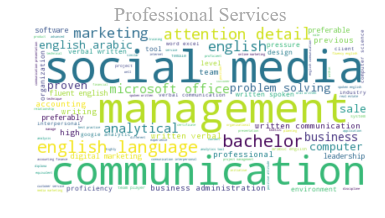

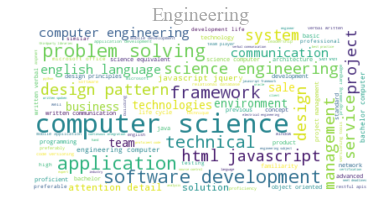

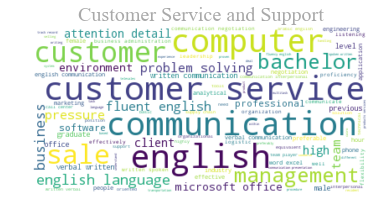

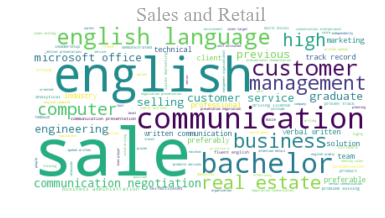

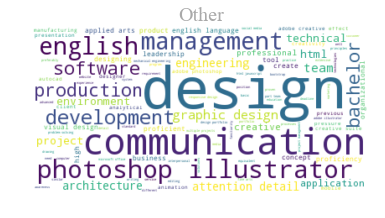

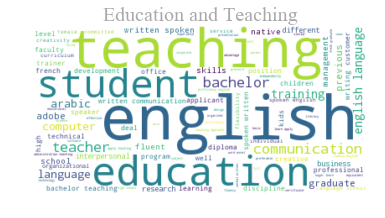

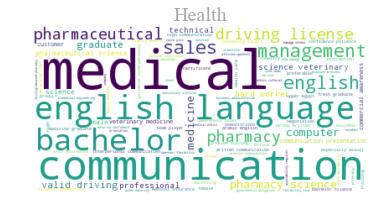

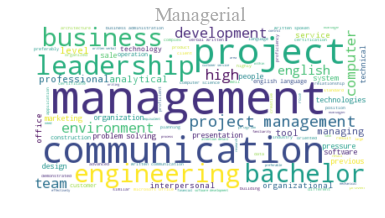

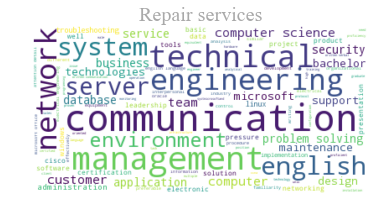

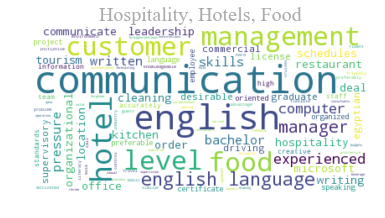

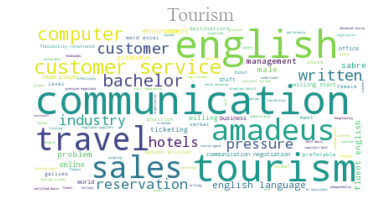

In [184]:
#create word cloud related to skills based on data

from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

#print(jobwords)
jobtext = {}
for key, word in jobtext_clean.items():
    if key != np.NAN:
        #print(key)
        title = key
        title = title.replace("/"," and ")
        if "Hospitality" in title:
            title = "Hospitality, Hotels, Food"
        wordcloud = WordCloud(background_color="white",max_words=100).generate(jobtext_clean[key])
        print(wordcloud)
        plt.title(title,fontname='times new roman',color='darkgrey',fontsize=20)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.savefig(title+'.png')
        plt.show()
